In [365]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:35931 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [3]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

13.933279752731323


# Prepare data for processing

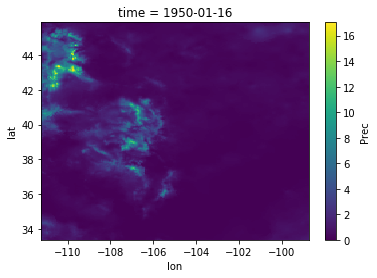

In [342]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(300,500), lon=slice(220,420), time=slice(0,200))
#ds2 = ds.isel(time=slice(0,60))
ds2.Prec.isel(time=0).load()
ds2.Prec.isel(time=0).plot()

In [135]:
#Stack the data along the space time axis
#ds3 = ds2.stack(points=['lon','lat'])

In [136]:
#Shape the data
#shape = ds3.Prec.data
#shape = da.transpose(shape)
#shape

# The following is one level of MRA Cluster:

# Compute DWT

In [479]:
#Set the number of levels for DWT, as well as the wavelet
min_len = min(ds2.Prec.data.shape)
levels = 1
wave = 'haar'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = min_len, filter_len = pywt.Wavelet(wave).dec_len) 

In [480]:
max_level

7

In [481]:
#Perform dwt on quantized data.

#wp = pywt.wavedec(data=shape, wavelet=wave, level = min(levels,max_level))
#wp = pywt.dwtn(data=data_quant, wavelet=wave)
wp = pywt.wavedecn(data=ds2.Prec.data, wavelet=wave, level = min(levels,max_level))

In [482]:
wp[0].shape

(100, 100, 100)

In [483]:
#Flatten data above a certain threshold?

#View the distribution of the DWT values
np.histogram(wp[0], bins=100, range =[np.nanmin(wp[0]), np.nanmax(wp[0])])

(array([ 92146, 139793, 122381,  99737,  83185,  70592,  60505,  52516,
         44287,  37382,  31625,  27372,  23411,  19534,  16477,  13840,
         11183,   9406,   7671,   6372,   5403,   4434,   3686,   3054,
          2558,   1971,   1562,   1324,   1085,    891,    787,    718,
           516,    474,    406,    344,    274,    243,    160,    130,
            97,     74,     63,     44,     48,     29,     27,     25,
            17,     19,      8,     14,     15,     13,     10,      7,
            11,      2,      5,      6,      1,      3,      5,      4,
             2,      1,      1,      1,      0,      1,      3,      1,
             1,      2,      1,      1,      0,      0,      0,      0,
             0,      1,      0,      1,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      1]),
 array([ 0.        ,  0.51436264,  1.02872528,  1.54308792,  2.05745056,
         2.5718132 , 

# Cluster data at chosen level

In [161]:
# Here we use DBScan to automatically chose our clusters.  It might be better to have an adaptive method, 
# choosing a clustering algorithm based off size of wavelet data

In [484]:
#Reshape the data
shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
shaped = np.transpose(shaped)
shaped.shape

(10000, 100)

In [485]:
#Discover the epsilon for DBScan using knn.  May want to alter the metric.
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(shaped)
distances, indices = nbrs.kneighbors(shaped)

#Set the distance to use as within 98th percentile:
epsilon = np.percentile(distances[:,[1,-1]], 98)

In [475]:
connection = nbrs.radius_neighbors_graph(shaped, radius = epsilon).toarray()
connection = np.sum(connection, axis=1)
np.histogram(connection, bins = 72)

(array([23, 26,  9, 19, 21, 17, 21, 20, 10, 16, 13,  7, 13,  3, 10, 12,  5,
         6,  7,  4, 10,  7,  2,  7,  4,  8, 10,  4, 14,  7,  6, 16, 17,  7,
        13,  3,  7,  8, 11, 12, 12,  4,  9, 15,  9, 12,  5,  7,  8,  6, 12,
        11,  7,  4,  5,  7,  8, 10,  2,  5,  6,  7, 11,  0,  3,  3,  0,  1,
         0,  0,  0,  1]),
 array([  1.        ,   3.63888889,   6.27777778,   8.91666667,
         11.55555556,  14.19444444,  16.83333333,  19.47222222,
         22.11111111,  24.75      ,  27.38888889,  30.02777778,
         32.66666667,  35.30555556,  37.94444444,  40.58333333,
         43.22222222,  45.86111111,  48.5       ,  51.13888889,
         53.77777778,  56.41666667,  59.05555556,  61.69444444,
         64.33333333,  66.97222222,  69.61111111,  72.25      ,
         74.88888889,  77.52777778,  80.16666667,  82.80555556,
         85.44444444,  88.08333333,  90.72222222,  93.36111111,
         96.        ,  98.63888889, 101.27777778, 103.91666667,
        106.55555556, 109.1944

In [486]:
#Choose parameters for dbscan.  This should depend on the resolution, and stats of the data at given resolution


#Minimum number of samples needed to classify a cluster
min_size = 2

#Will likely want to change the metric as well

In [487]:
#Perform db scan and return the result
classes = DBSCAN(eps=epsilon, min_samples=min_size).fit_predict(shaped)

In [488]:
#Reshape classes to match back up with original
classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))

In [489]:
np.histogram(classes, bins = np.max(classes)+1)

(array([ 131, 9707,    4,    5,    3,    8,    2,    2,    2,    3,    3,
           2,    2,    2,    4,    2,    6,    4,    5,    2,    2,   10,
           2,    3,    2,    4,    3,    2,    4,    3,    3,    8,    5,
           3,    2,    2,    2,    2,    5,    2,    3,    2,    2,    2,
           2,    3,    2,    2,    3,    4,    3,    4]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
        38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
        51.]))

# Map classes back to (lat,lon) points

In [446]:
#In general, the inverse map will depend on the choice of wavelet.
#For now, we only use the Haar wavelet
#Also, only works for origoinal data selected to have even size (odd size need to adjust)

In [447]:
classes.shape

(25, 25)

In [448]:
#Create index matricies to inflate data back to same size:
for j in range(min(levels,max_level)):
    L = np.kron(np.eye(classes.shape[0]), np.array([[1],[1]]))
    R = np.kron(np.eye(classes.shape[1]), np.array([[1, 1]]))
    classes = np.matmul(np.matmul(L, classes),R)

In [449]:
classes.shape

(200, 200)

# Discover Final Classes

In [ ]:
# For each resolution, we get a classes array. The class label is a vector (l_1, ... l_K), where K is the number of 
# levels computed. 